# Problem 2: Heterogeneous Priors

Three-coin Bernoulli bandit where the designer's prior over success probabilities is:

- $p_1 \sim \text{Beta}(1, 0.1)$
- $p_2 \sim \text{Beta}(1, 0.2)$
- $p_3 \sim \text{Beta}(1, 0.3)$

We compare two Thompson Sampling agents:

1. **Heterogeneous priors**: $\alpha_i = 1$, $\beta_1 = 0.1$, $\beta_2 = 0.2$, $\beta_3 = 0.3$
2. **Homogeneous priors**: $\alpha_i = 1$, $\beta_1 = \beta_2 = \beta_3 = 0.2$

**Parameters:** `num_sims = 1000`, `num_timesteps = 10000`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

NUM_SIMS = 1000
NUM_TIMESTEPS = 10000

## Environment and Agent Definitions

In [2]:
class BernoulliBandit:
    """Bernoulli bandit environment with K arms."""
    def __init__(self, probs):
        self.probs = np.array(probs)
        self.k = len(probs)
        self.best_arm = np.argmax(probs)
        self.best_prob = np.max(probs)

    def pull(self, arm):
        return np.random.binomial(1, self.probs[arm])


class ThompsonSamplingAgent:
    """Thompson Sampling with configurable Beta priors."""
    def __init__(self, alpha_prior, beta_prior):
        self.k = len(alpha_prior)
        self.alpha = np.array(alpha_prior, dtype=float)
        self.beta = np.array(beta_prior, dtype=float)

    def select_arm(self):
        samples = np.array([
            np.random.beta(self.alpha[a], self.beta[a]) for a in range(self.k)
        ])
        return np.argmax(samples)

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

## Simulation

For each simulation:
1. Draw $p_1, p_2, p_3$ from the designer's prior
2. Run both Thompson Sampling agents on the same bandit instance
3. Track per-timestep regret: $p^* - p_{a_t}$

The expected cumulative regret is averaged over the designer's prior (i.e., over all simulations).

In [3]:
# Designer's prior parameters
designer_alpha = [1.0, 1.0, 1.0]
designer_beta = [0.1, 0.2, 0.3]

# Agent prior parameters
hetero_alpha = [1.0, 1.0, 1.0]
hetero_beta = [0.1, 0.2, 0.3]

homo_alpha = [1.0, 1.0, 1.0]
homo_beta = [0.2, 0.2, 0.2]

# Storage for regret
regret_hetero = np.zeros((NUM_SIMS, NUM_TIMESTEPS))
regret_homo = np.zeros((NUM_SIMS, NUM_TIMESTEPS))

for sim in range(NUM_SIMS):
    if (sim + 1) % 200 == 0:
        print(f"Simulation {sim + 1}/{NUM_SIMS}")

    # Draw coin probabilities from designer's prior
    probs = [
        np.random.beta(designer_alpha[i], designer_beta[i])
        for i in range(3)
    ]
    env = BernoulliBandit(probs)

    # Initialize both agents
    agent_hetero = ThompsonSamplingAgent(hetero_alpha.copy(), hetero_beta.copy())
    agent_homo = ThompsonSamplingAgent(homo_alpha.copy(), homo_beta.copy())

    for t in range(NUM_TIMESTEPS):
        # Heterogeneous agent
        arm_h = agent_hetero.select_arm()
        reward_h = env.pull(arm_h)
        regret_hetero[sim, t] = env.best_prob - env.probs[arm_h]
        agent_hetero.update(arm_h, reward_h)

        # Homogeneous agent
        arm_o = agent_homo.select_arm()
        reward_o = env.pull(arm_o)
        regret_homo[sim, t] = env.best_prob - env.probs[arm_o]
        agent_homo.update(arm_o, reward_o)

print("Done.")

Simulation 200/1000


Simulation 400/1000


Simulation 600/1000


Simulation 800/1000


Simulation 1000/1000
Done.


## Compute Expected Cumulative Regret

In [4]:
# Average per-timestep regret across simulations (expectation over designer's prior)
avg_regret_hetero = np.mean(regret_hetero, axis=0)
avg_regret_homo = np.mean(regret_homo, axis=0)

# Expected cumulative regret
cum_regret_hetero = np.cumsum(avg_regret_hetero)
cum_regret_homo = np.cumsum(avg_regret_homo)

print(f"Expected cumulative regret at T={NUM_TIMESTEPS}:")
print(f"  Heterogeneous priors: {cum_regret_hetero[-1]:.2f}")
print(f"  Homogeneous priors:   {cum_regret_homo[-1]:.2f}")
print(f"  Difference (homo - hetero): {cum_regret_homo[-1] - cum_regret_hetero[-1]:.2f}")

Expected cumulative regret at T=10000:
  Heterogeneous priors: 4.76
  Homogeneous priors:   4.97
  Difference (homo - hetero): 0.21


## Plots

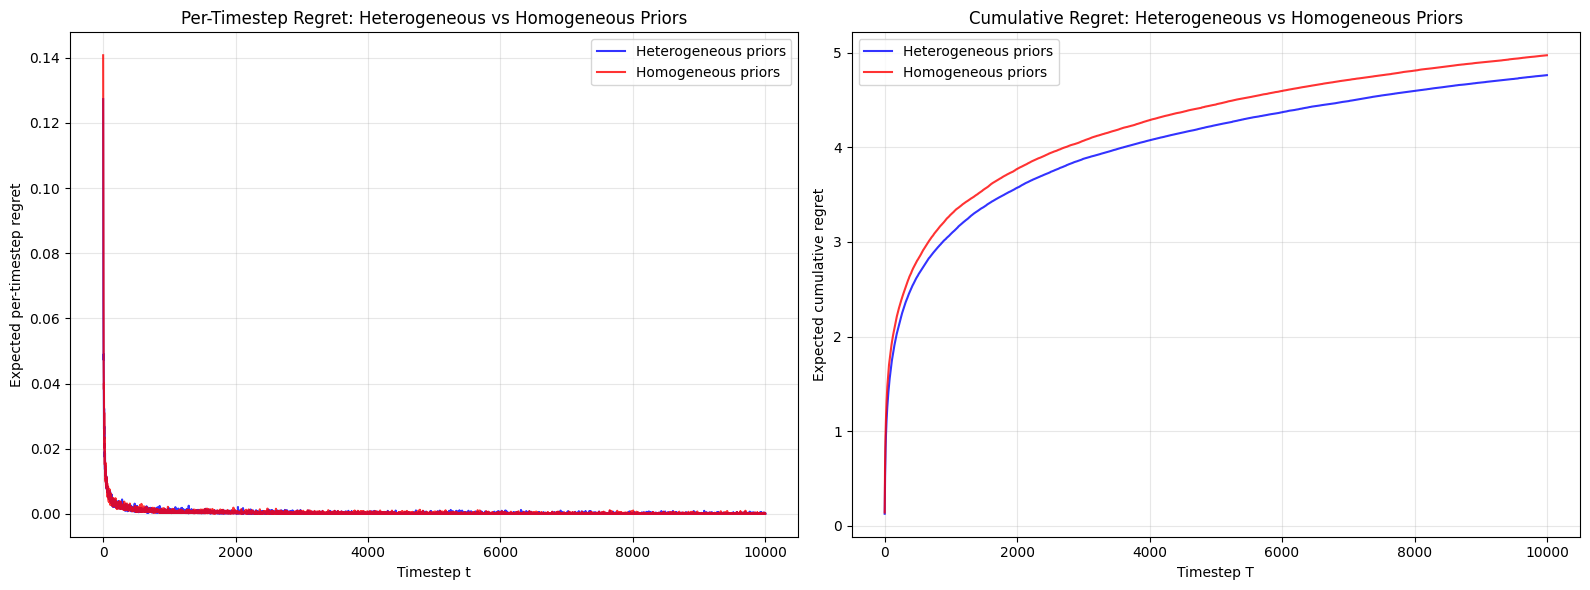

Saved: heterogeneous_priors_regret.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Per-timestep regret
ax = axes[0]
ax.plot(avg_regret_hetero, label='Heterogeneous priors', color='blue', alpha=0.8)
ax.plot(avg_regret_homo, label='Homogeneous priors', color='red', alpha=0.8)
ax.set_xlabel('Timestep t')
ax.set_ylabel('Expected per-timestep regret')
ax.set_title('Per-Timestep Regret: Heterogeneous vs Homogeneous Priors')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative regret
ax = axes[1]
ax.plot(cum_regret_hetero, label='Heterogeneous priors', color='blue', alpha=0.8)
ax.plot(cum_regret_homo, label='Homogeneous priors', color='red', alpha=0.8)
ax.set_xlabel('Timestep T')
ax.set_ylabel('Expected cumulative regret')
ax.set_title('Cumulative Regret: Heterogeneous vs Homogeneous Priors')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('heterogeneous_priors_regret.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: heterogeneous_priors_regret.png")

## Additional Analysis: Regret at Key Timesteps

In [6]:
checkpoints = [100, 500, 1000, 2000, 5000, 10000]

print(f"{'T':>6}  {'Hetero':>10}  {'Homo':>10}  {'Diff':>10}  {'% Improvement':>15}")
print('-' * 60)
for T in checkpoints:
    h = cum_regret_hetero[T - 1]
    o = cum_regret_homo[T - 1]
    diff = o - h
    pct = 100 * diff / o if o > 0 else 0
    print(f"{T:>6}  {h:>10.2f}  {o:>10.2f}  {diff:>10.2f}  {pct:>14.1f}%")

     T      Hetero        Homo        Diff    % Improvement
------------------------------------------------------------
   100        1.70        1.89        0.20            10.5%
   500        2.64        2.81        0.17             6.1%
  1000        3.08        3.29        0.20             6.2%
  2000        3.57        3.77        0.20             5.3%
  5000        4.23        4.45        0.22             4.9%
 10000        4.76        4.97        0.21             4.2%


## Standard Error Bands

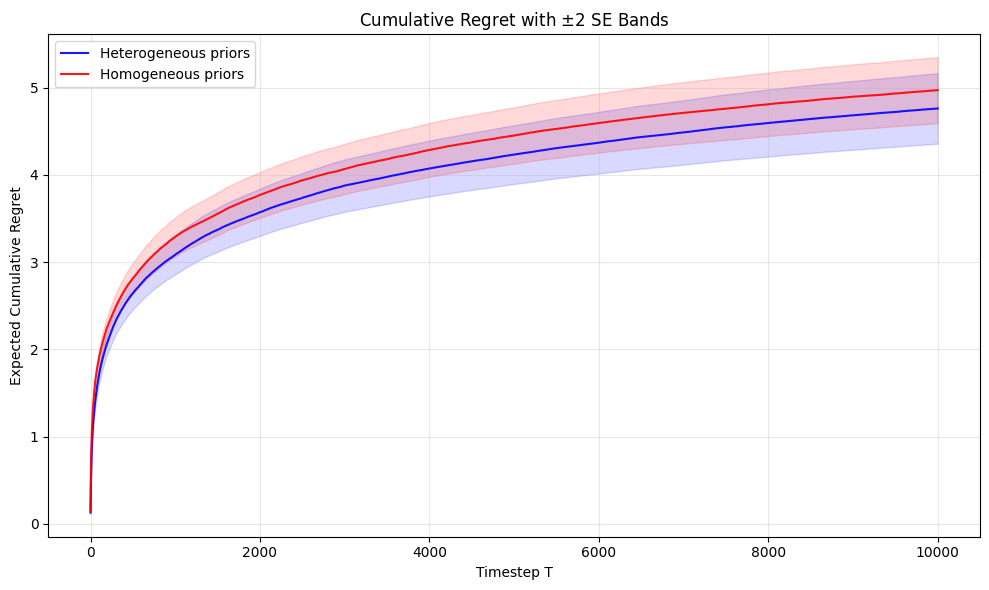

Saved: heterogeneous_priors_regret_se.png


In [7]:
# Compute cumulative regret per simulation for confidence bands
cum_regret_hetero_all = np.cumsum(regret_hetero, axis=1)
cum_regret_homo_all = np.cumsum(regret_homo, axis=1)

mean_cum_hetero = np.mean(cum_regret_hetero_all, axis=0)
mean_cum_homo = np.mean(cum_regret_homo_all, axis=0)
se_cum_hetero = np.std(cum_regret_hetero_all, axis=0) / np.sqrt(NUM_SIMS)
se_cum_homo = np.std(cum_regret_homo_all, axis=0) / np.sqrt(NUM_SIMS)

fig, ax = plt.subplots(figsize=(10, 6))

timesteps = np.arange(NUM_TIMESTEPS)

ax.plot(timesteps, mean_cum_hetero, label='Heterogeneous priors', color='blue', alpha=0.9)
ax.fill_between(timesteps,
                mean_cum_hetero - 2 * se_cum_hetero,
                mean_cum_hetero + 2 * se_cum_hetero,
                color='blue', alpha=0.15)

ax.plot(timesteps, mean_cum_homo, label='Homogeneous priors', color='red', alpha=0.9)
ax.fill_between(timesteps,
                mean_cum_homo - 2 * se_cum_homo,
                mean_cum_homo + 2 * se_cum_homo,
                color='red', alpha=0.15)

ax.set_xlabel('Timestep T')
ax.set_ylabel('Expected Cumulative Regret')
ax.set_title('Cumulative Regret with $\pm 2$ SE Bands')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('heterogeneous_priors_regret_se.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: heterogeneous_priors_regret_se.png")

## Analysis

**Is there an advantage to initializing Thompson Sampling with heterogeneous priors when the
designer's priors are heterogeneous?**

Yes. The heterogeneous prior agent matches the designer's prior exactly, which means it starts
with the correct belief about each coin's success probability. Under the designer's prior,
coin 1 is likely the best ($p_1 \sim \text{Beta}(1, 0.1)$ has mean $\approx 0.91$), coin 2 is
second ($p_2 \sim \text{Beta}(1, 0.2)$ has mean $\approx 0.83$), and coin 3 is worst
($p_3 \sim \text{Beta}(1, 0.3)$ has mean $\approx 0.77$).

The heterogeneous agent encodes this ordering in its prior, so it explores more efficiently:
it pulls arm 1 more often initially (since its prior mean is highest), which is usually the
correct arm. The homogeneous agent, by contrast, assigns equal prior means to all arms and
must spend more time exploring to discover the ordering.

This advantage is most pronounced in early timesteps. As both agents accumulate data, their
posteriors converge to the truth regardless of initialization. However, the initial regret
savings of the heterogeneous agent persist in the cumulative regret throughout the horizon.